# Non-Negative Matrix Factorization (NMF) and Multidimensional scaling

Some notes I've discovered during my search for Instagram user distance.


In [2]:
import psycopg2
import psycopg2.extras
from string import digits
from stopwords_czech import stopwords_czech

import psycopg2.extensions
psycopg2.extensions.register_type(psycopg2.extensions.UNICODE)
psycopg2.extensions.register_type(psycopg2.extensions.UNICODEARRAY)

conn = psycopg2.connect("dbname=instagram_lda user=pc")
cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)

cur.execute("SELECT raw_text FROM media")
media = cur.fetchall()
media = map(lambda i: i[0], media)

In [3]:
import numpy as np # a conventional alias

import sklearn.feature_extraction.text as text

vectorizer = text.CountVectorizer(input='content', strip_accents='ascii', stop_words='english', min_df=20)

dtm = vectorizer.fit_transform(media).toarray()

vocab = np.array(vectorizer.get_feature_names())

In [4]:
from sklearn import decomposition

num_topics = 10

num_top_words = 5

clf = decomposition.NMF(n_components=num_topics, random_state=1)

doctopic = clf.fit_transform(dtm)

In [5]:
# print words associated with topics
topic_words = []

for topic in clf.components_:
    word_idx = np.argsort(topic)[::-1][0:num_top_words]
    topic_words.append([vocab[i] for i in word_idx])
topic_words

[[u'vscocze', u'vscocam', u'vsco', u'igerscz', u'liveauthentic'],
 [u'na', u'se', u'je', u'si', u'jsem'],
 [u'igerscz', u'livefolk', u'czech', u'inspiration', u'czechrepublic'],
 [u'prague', u'czech', u'praha', u'architecture', u'view'],
 [u'new', u'day', u'today', u'like', u'just'],
 [u'czechgirl', u'czech', u'igerscz', u'czechrepublic', u'laska'],
 [u'iglifecz', u'igerscz', u'liveauthentic', u'nature', u'photo'],
 [u'vscocam', u'vsco', u'nofilter', u'coffee', u'nature'],
 [u'igers', u'igerscz', u'instagood', u'czech_vibes', u'travel'],
 [u'love', u'happy', u'girl', u'breakfast', u'today']]

In [6]:
doctopic = doctopic / np.sum(doctopic, axis=1, keepdims=True)

In [7]:
cur.execute("SELECT username FROM media")
usernames = cur.fetchall()
usernames = map(lambda i: i[0], usernames)


# turn this into an array so we can use NxumPy functions
usernames = np.asarray(usernames)

doctopic_orig = doctopic.copy()

# use method described in preprocessing section
num_groups = len(set(usernames))

doctopic_grouped = np.zeros((num_groups, num_topics))

for i, name in enumerate(sorted(set(usernames))):
    doctopic_grouped[i, :] = np.mean(doctopic[usernames == name, :], axis=0)

doctopic = doctopic_grouped

In [8]:
novels = sorted(set(usernames))

print("Top NMF topics in...")

for i in range(len(doctopic)):
    top_topics = np.argsort(doctopic[i,:])[::-1][0:3]
    top_topics_str = ' '.join(str(t) for t in top_topics)
    print("{}: {}".format(novels[i], top_topics_str))


Top NMF topics in...
_dzejny                                           : 1 4 8
abdoc                                             : 4 3 1
adam.marcan                                       : 4 9 3
adrinellaina                                      : 1 5 9
aguynamedpatrick                                  : 4 9 3
alexandrapotsch                                   : 1 9 5
alini_x                                           : 9 1 4
an_yochim                                         : 3 1 9
anduiyn                                           : 7 4 0
anetaanie                                         : 6 8 7
angelynpeh                                        : 7 4 9
annabrezinova                                     : 7 6 2
annamariehradecka                                 : 4 1 9
annaningerova                                     : 6 7 0
annavratilova                                     : 0 7 8
ansvarcova                                        : 1 9 4
baralousova                                       :

In [9]:
N, K = doctopic.shape
topic_labels = ['Topic #{}'.format(k) for k in range(K)]

%matplotlib inline
import matplotlib.pyplot as plt

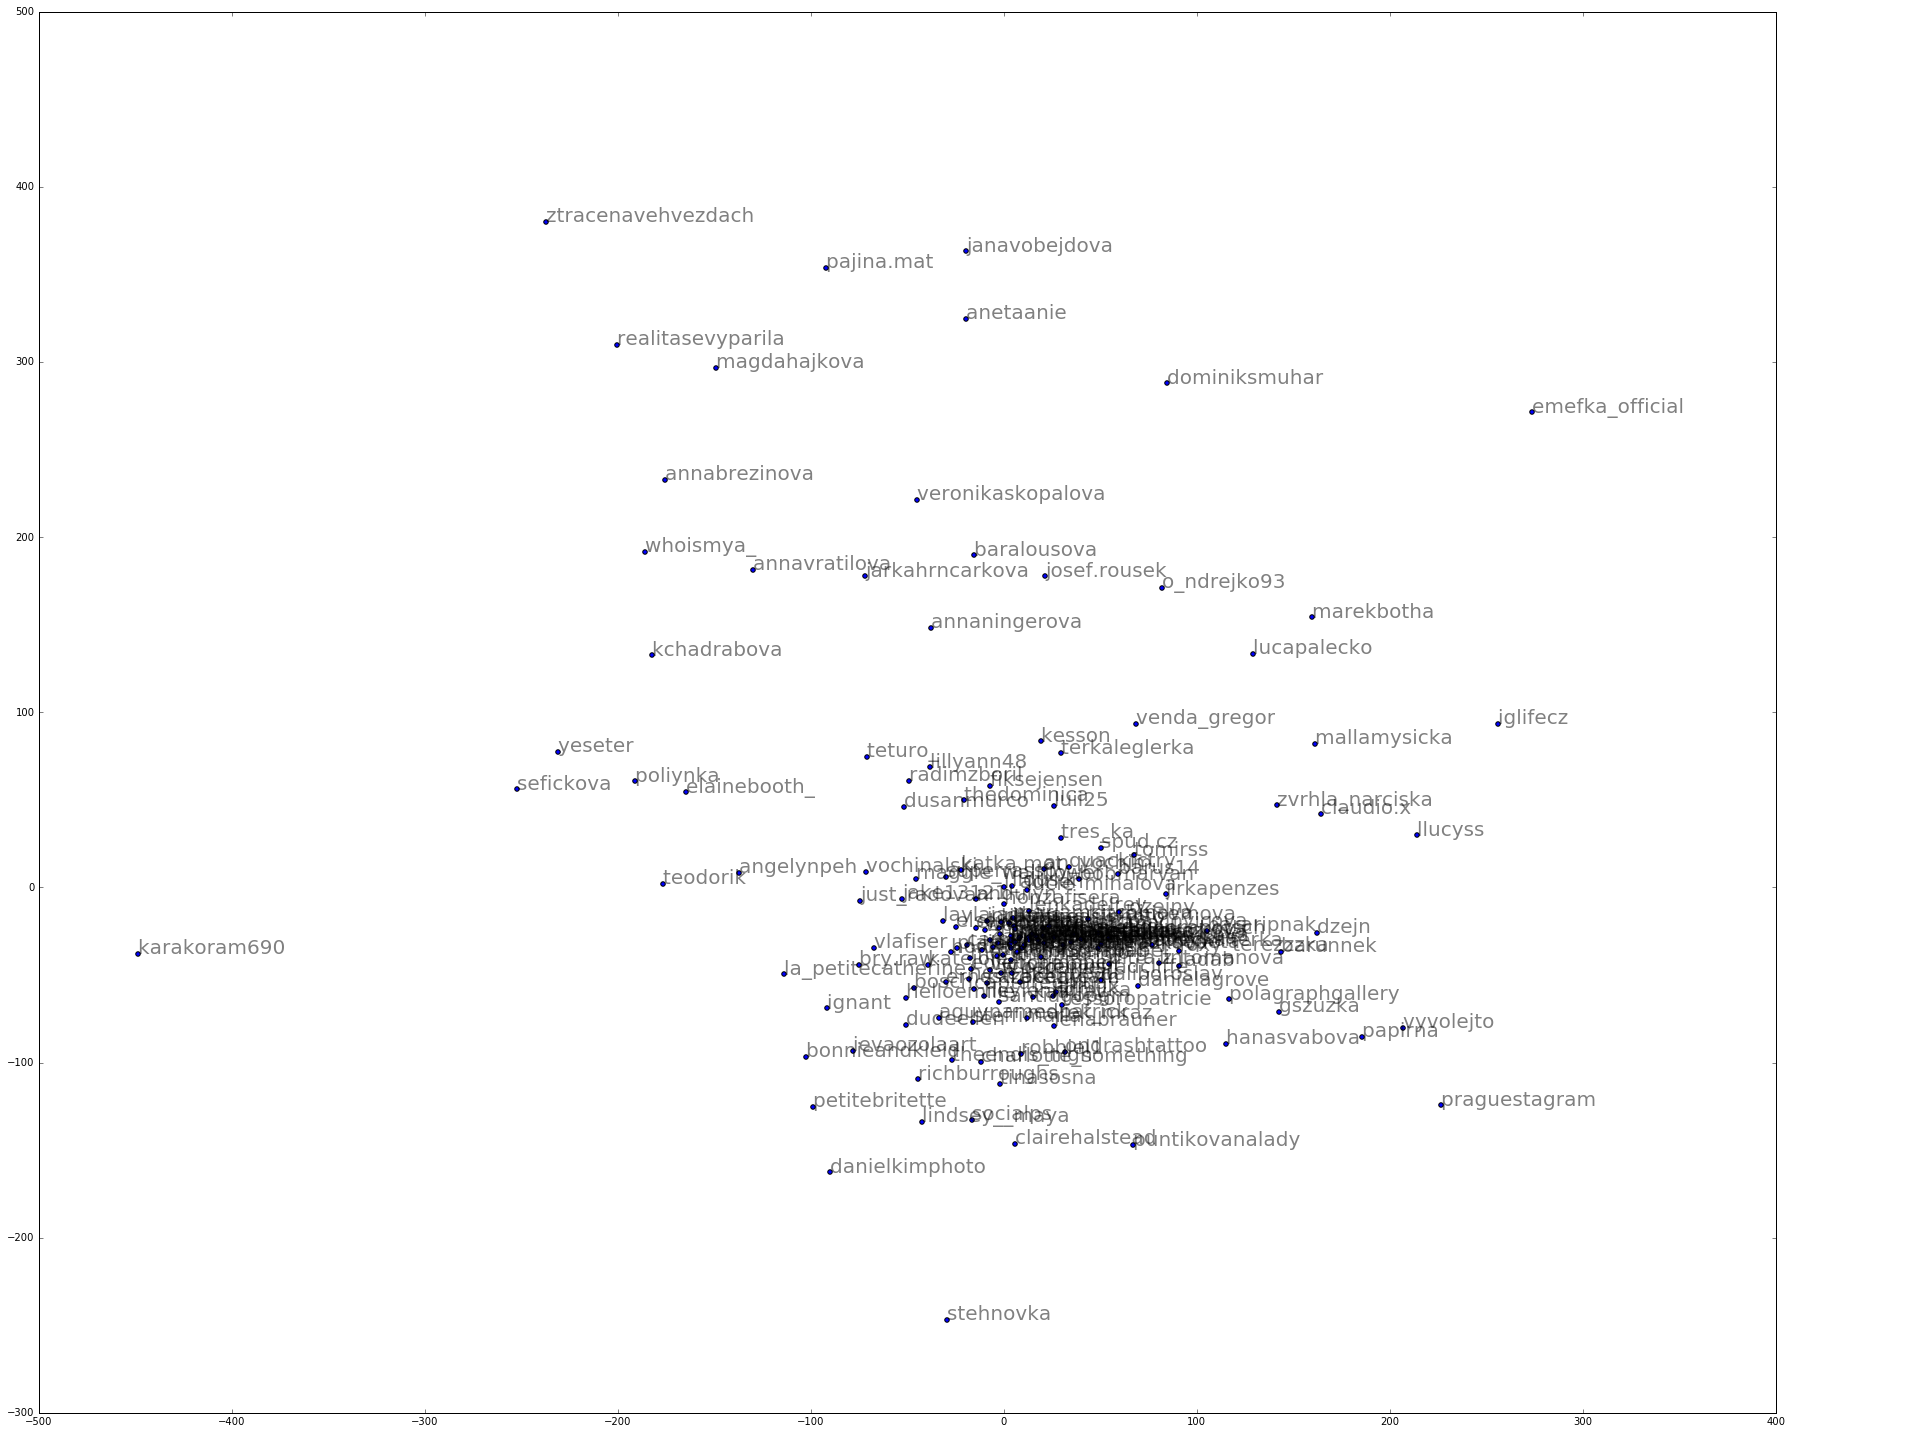

In [14]:
from sklearn.manifold import MDS

from sklearn.metrics.pairwise import cosine_similarity

# we need distance, not similarity
# dist = 1 - cosine_similarity(dtm)
# mds = MDS(n_components=3, dissimilarity="precomputed")
# pos = mds.fit_transform(dist)  # shape (n_components, n_samples)


mds = MDS(n_components=2, dissimilarity="euclidean")

pos = mds.fit_transform(dtm)  # shape (n_components, n_samples)

plt.figure(figsize=(25, 20))  # use a bigger canvas than usual

xs, ys = pos[:, 0], pos[:, 1]


plt.scatter(xs, ys)

for x, y, name in zip(xs, ys, usernames):
    plt.text(x, y, name, alpha=0.5, fontsize=20)

plt.tight_layout()

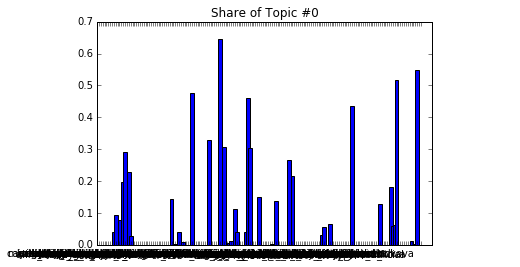

In [12]:
ind = np.arange(N)  # points on the x-axis

width = 2

plt.bar(ind, doctopic[:,0], width=width)

plt.xticks(ind + width/2, usernames)  # put labels in the center

plt.title('Share of Topic #0')
plt.show()

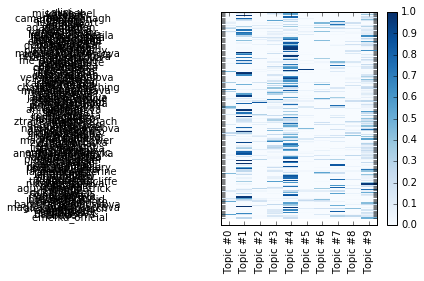

In [13]:
plt.pcolor(doctopic, norm=None, cmap='Blues')

# put the major ticks at the middle of each cell
# the trailing semicolon ';' suppresses output
plt.yticks(np.arange(doctopic.shape[0])+0.5, usernames);

plt.xticks(np.arange(doctopic.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')

plt.tight_layout()  # fixes margins

plt.show()